In [1]:
"""
Created on Wed Oct 18 17:46:23 2023

@author: RJha
"""
import os
import xarray as xr
import numpy as np
from pyhomogeneity import pettitt_test
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm

/home/r/Roshan.Jha/.local/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


In [9]:
uvth = xr.open_dataset('UVTH_Daily.nc')
wv = xr.open_dataset('../WV_Daily.nc')
R1_HW_days = xr.open_dataset('../Regime1_hot_days_1973_2022_NM.nc')
R2_HW_days = xr.open_dataset('../Regime2_hot_days_1973_2022_NM.nc')

In [25]:
ds = xr.open_dataset('../NCI_Heatwave_Days.nc')
ds_R1 = ds.sel(time=slice('1973','1997'))
ds_R2 = ds.sel(time=slice('1998','2022'))  

In [27]:
ds_R2

<xarray.Dataset>
Dimensions:                        (time: 195)
Coordinates:
  * time                           (time) datetime64[ns] 1998-05-21 ... 2022-...
Data variables:
    __xarray_dataarray_variable__  (time) datetime64[ns] ...
Attributes:
    __xarray_dataarray_name__:  time

In [10]:
R1_hot_days = R1_HW_days['time'][R1_HW_days['hd'] > 0]
R2_hot_days = R2_HW_days['time'][R2_HW_days['hd'] > 0]

In [11]:
R2_hot_days

<xarray.DataArray 'time' (time: 233)>
array(['1998-05-20T00:00:00.000000000', '1998-05-21T00:00:00.000000000',
       '1998-05-22T00:00:00.000000000', ..., '2022-05-13T00:00:00.000000000',
       '2022-05-14T00:00:00.000000000', '2022-05-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1998-05-20 1998-05-21 ... 2022-05-15

In [5]:
uwind = uvth.u
vwind = uvth.v
gph = uvth.z
vort = wv.vo

In [12]:
uwind_R1 = uwind.sel(level=[200,500],time=R1_hot_days.time.values)
uwind_R2 = uwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = uwind_R1.latitude.values
lons = uwind_R1.longitude.values
levs = uwind_R1.level.values

diff_R2_R1 = uwind_R2.mean(dim=['time']) - uwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(uwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(uwind_R1[:,k,i,j], uwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


uwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), uwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), uwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
vwind_R1 = vwind.sel(level=[200,500],time=R1_hot_days.time.values)
vwind_R2 = vwind.sel(level=[200,500],time=R2_hot_days.time.values)

lats = vwind_R1.latitude.values
lons = vwind_R1.longitude.values
levs = vwind_R1.level.values

diff_R2_R1 = vwind_R2.mean(dim=['time']) - vwind_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(vwind_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(vwind_R1[:,k,i,j], vwind_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


vwind_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), vwind_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), vwind_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

############
                            
gph_R1 = gph.sel(level=[200,500],time=R1_hot_days.time.values)/9.80665
gph_R2 = gph.sel(level=[200,500],time=R2_hot_days.time.values)/9.80665

lats = gph_R1.latitude.values
lons = gph_R1.longitude.values
levs = gph_R1.level.values

diff_R2_R1 = gph_R2.mean(dim=['time']) - gph_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(gph_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(gph_R1[:,k,i,j], gph_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


gph_Regime = xr.Dataset({"1973-1997": (('level','lat','lon'), gph_R1.mean(dim=['time']).values),
                           "1998-2022": (('level','lat','lon'), gph_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})

######
                        

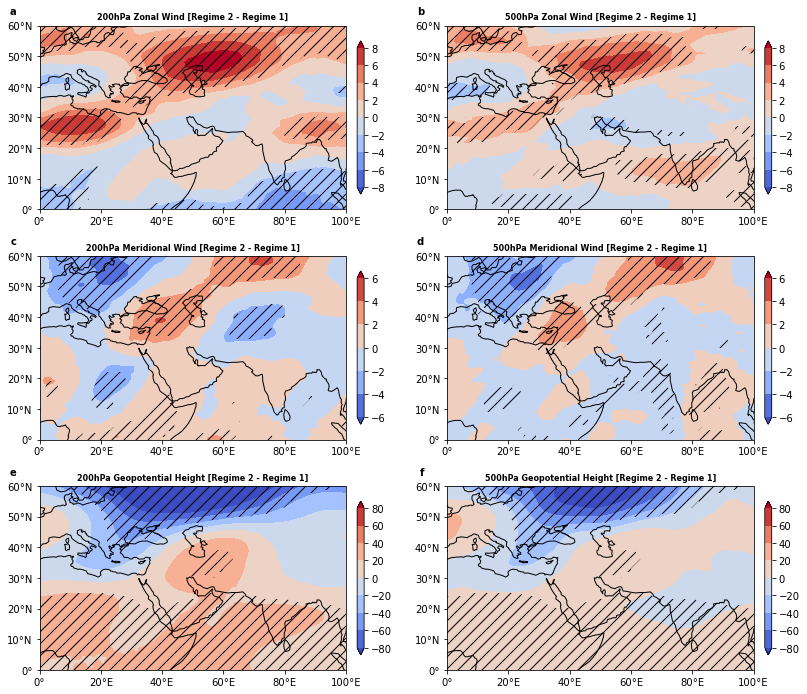

In [14]:

fig = plt.figure(figsize=(14,12))
plev=200

ax1 = plt.subplot2grid(shape=(3,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax1.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax1.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax1.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes,color='k', weight='bold')

####

ax2 = plt.subplot2grid(shape=(3,4), loc=(1, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax2.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax2.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax2.text(-0.075, 1.05, 'c',verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes,color='k', weight='bold')

######

ax3 = plt.subplot2grid(shape=(3,4), loc=(2, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=200)
clevs=np.arange(-80,90,20)
cf_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax3.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax3.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax3.text(-0.075, 1.05, 'e',verticalalignment='bottom', horizontalalignment='right',transform=ax3.transAxes,color='k', weight='bold')

###########################################################
plev=500

ax4 = plt.subplot2grid(shape=(3,4), loc=(0, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = uwind_Regime.dif.sel(level=plev)
clevs=np.arange(-8,9,2)
cf_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(uwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax4.contourf(uwind_Regime.lon, uwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax4.set_title(f'{plev}hPa Zonal Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax4.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')

####

ax5 = plt.subplot2grid(shape=(3,4), loc=(1, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vwind_Regime.dif.sel(level=plev)
clevs=np.arange(-6,7,2)
cf_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(vwind_Regime.sig.sel(level=plev) == 1, 1, np.nan)
hatch_plot = ax5.contourf(vwind_Regime.lon, vwind_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)
ax5.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax5.set_title(f'{plev}hPa Meridional Wind [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax5.text(-0.075, 1.05, 'd',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

######

ax6 = plt.subplot2grid(shape=(3,4), loc=(2, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = gph_Regime.dif.sel(level=plev)
clevs=np.arange(-80,90,20)
cf_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, data,clevs, transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
pvalue_mask = np.where(gph_Regime.sig.sel(level=200) == 1, 1, np.nan)
hatch_plot = ax6.contourf(gph_Regime.lon, gph_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax6.yaxis.set_major_formatter(lat_formatter)
ax6.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())
ax6.set_title(f'{plev}hPa Geopotential Height [Regime 2 - Regime 1]',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax6.text(-0.075, 1.05, 'f',verticalalignment='bottom', horizontalalignment='right',transform=ax6.transAxes,color='k', weight='bold')

plt.savefig('Figure_5_NM.jpg', dpi=600,bbox_inches='tight')

In [15]:
vort_R1 = vort.sel(time=R1_hot_days.time.values)
vort_R2 = vort.sel(time=R2_hot_days.time.values)

lats = vort_R1.latitude.values
lons = vort_R1.longitude.values
levs = vort_R1.level.values

diff_R2_R1 = vort_R2.mean(dim=['time']) - vort_R1.mean(dim=['time'])

###############t-test with unequal variance#########################################################

result = np.zeros([len(levs),len(lats),len(lons)])
sig = np.zeros([len(levs),len(lats),len(lons)])
sig[:] = np.nan

for k,lev in enumerate(levs):
    for i,lat in enumerate(lats):
        for j,lon in enumerate(lons):
            if (np.isnan(vort_R1[0,k,i,j])):
                result[k,i,j] = np.nan
            else:
                t, p = stats.ttest_ind(vort_R1[:,k,i,j], vort_R2[:,k,i,j],equal_var=False) 
                result[k,i,j]=t
                if p<0.05:
                    sig[k,i,j]=1


vort_Regime = xr.Dataset({"Regime1": (('level','lat','lon'), vort_R1.mean(dim=['time']).values),
                           "Regime2": (('level','lat','lon'), vort_R2.mean(dim=['time']).values),
                           "dif": (('level','lat','lon'), diff_R2_R1.values),
                           "sig": (('level','lat','lon'), sig)},
                          coords={'level': levs,'lat': lats, 'lon': lons})                         

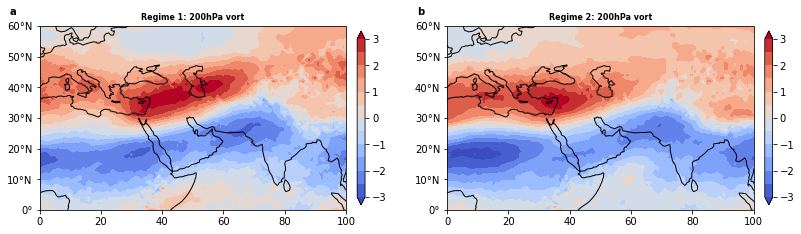

In [16]:
fig = plt.figure(figsize=(14,4))

plev=200
ax4 = plt.subplot2grid(shape=(1,4), loc=(0, 0), colspan=2, fig=fig, projection=ccrs.PlateCarree())
clevs=np.arange(-3,3.5,0.5)
data = vort_Regime.Regime1.sel(level=plev)*10**5

# Plot the trend data using contourf
cf_plot = ax4.contourf(vort_Regime.lon, vort_Regime.lat, data,clevs,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
# Add hatching to the sections where p-value is 1
#pvalue_mask = np.where(vort_Regime.sig.sel(level=plev) == 1, 1, np.nan)
#hatch_plot = ax4.contourf(vort_Regime.lon, vort_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax4.coastlines()

# Longitude labels
ax4.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
#ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax4.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax4.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax4.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())

# Title
ax4.set_title(f'Regime 1: {plev}hPa vort',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax4.text(-0.075, 1.05, 'a',verticalalignment='bottom', horizontalalignment='right',transform=ax4.transAxes,color='k', weight='bold')
####

ax5 = plt.subplot2grid(shape=(1,4), loc=(0, 2), colspan=2, fig=fig, projection=ccrs.PlateCarree())
data = vort_Regime.Regime2.sel(level=plev)*10**5

# Plot the trend data using contourf
cf_plot = ax5.contourf(vort_Regime.lon, vort_Regime.lat, data,clevs,transform=ccrs.PlateCarree(), cmap='coolwarm',extend='both' )#norm=norm
cbar = plt.colorbar(cf_plot, orientation='vertical', pad=0.03, shrink=0.8)
# Add hatching to the sections where p-value is 1
#pvalue_mask = np.where(vort_Regime.sig.sel(level=plev) == 1, 1, np.nan)
#hatch_plot = ax5.contourf(vort_Regime.lon, vort_Regime.lat, pvalue_mask, hatches=['//'], alpha=0, transform=ccrs.PlateCarree())

# Add coastlines and gridlines
ax5.coastlines()

# Longitude labels
ax5.set_xticks(np.arange(0,120,20), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
#ax4.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax5.set_yticks(np.arange(0,65,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax5.yaxis.set_major_formatter(lat_formatter)

# Crop the plot
ax5.set_extent([0, 100, 0, 60],crs=ccrs.PlateCarree())

# Title
ax5.set_title(f'Regime 2: {plev}hPa vort',fontdict={'fontsize': 8, 'fontweight': 'bold'})   
ax5.text(-0.075, 1.05, 'b',verticalalignment='bottom', horizontalalignment='right',transform=ax5.transAxes,color='k', weight='bold')

plt.savefig('Figure_SX_NM.jpg', dpi=600,bbox_inches='tight')